Engy-4350: Nuclear Reaction Engineering Sprint 2019 UMass Lowell; Prof. V. F. de Almeida **06Mar2019**

# Homework 03 06Mar2019 In-Class

### Name: `Valmor F. de Almeida`

### Rubric for each assignment: 

|      Context                       |  Points |
| -----------------------     | ------- |
| Precision of the answer     |   80%   |
| Answer Markdown readability |   10%   |
| Code readability            |   10%   |
    

### <span style="color:red">Guidance:</span>
 +  <span style="color:red"> 
    Save your work frequently to a file locally to your computer.
    </span>
 +  <span style="color:red">
    During your work and before submitting the final version do: `Kernel` -> `Restart & Run All`, to verify your notebook runs correctly.
    </span>
 +  <span style="color:red">
    Save your file again.
    </span>

---
### Table of Contents
* [Assignment 1 (50 pts)](#p1)
* [Assignment 2 (50 pts)](#p2)
---

## <span style="color:blue">Assignment 1 (50 pts).</span><a id="p1"></a>

### <span style="color:blue">Perform a sudden insertion of a steady source in a critical, steady state, fast reactor fueled with $^{239}$Pu using the 6-group delayed neutron emitter model. Use the data given in the course notes; provide the data in a tabular form with your work. From the transient response, compute the asymptotic slope of the neutron density curve and normalize by the source strength $q_0$. Compare this value with the theoretical limit.
</span>

Refer to Notebook 03a

### Input Data<a id="data"></a>

Name                        | Parameter          | Value                | Unit             |
----------------------------|--------------------|----------------------|------------------| 
neutron generation time     | $\ell$             | $1\times 10^{-8}$    |  s               | 
delayed neutron fraction    | $\beta$            | $2.04\times 10^{-3}$  |  -               |


For thermal fission of $^{235}$U the following six-group delayed neutron precursors data is typically used (*Physics of Nuclear Kinetics*, G. R. Keepin, 1965, Addison-Wesley Pub. Co.):


Delayed neutron emitter group No. | Decay cte ($\lambda_i$,1/sec) | Relative yield ($\beta_i/\beta$) |
----------------------------------|-------------------------------|----------------------------------| 
1                                 | 0.0129                        | 0.038                            |
2                                 | 0.0311                        | 0.280                            | 
3                                 | 0.134                         | 0.216                            |  
4                                 | 0.331                         | 0.328                            | 
5                                 | 1.26                         | 0.103                            |
6                                 | 3.21                          | 0.035                            |

In [44]:
#'''Parameters dictionary container'''

params = dict()

params['gen_time']          = 1.0e-8  # s
params['beta']              = 2.04e-3  # 
params['species_decay']     = [0.0129, 0.0311, 0.134, 0.331, 1.26, 3.21] # 1/sec
params['species_rel_yield'] = [0.038, 0.280, 0.216, 0.328, 0.103, 0.035] 

In [45]:
import numpy as np
assert np.abs(np.sum(np.array(params['species_rel_yield']))-1.0) <= 1.e-8

In [46]:
tau = np.array(params['species_rel_yield']) @ (1./np.array(params['species_decay']))
print('weighted mean lifetime of delayed neutrons %1.2f [s]'%tau)

weighted mean lifetime of delayed neutrons 14.64 [s]


In [47]:
'''Setup function for delayed neutron species concentrations at steady state'''

def setup_initial_conditions(params):
    
    # setup the steady state for the delayed-neutron precursors
    
    n_species = len( params['species_decay'] )
    
    assert len(params['species_rel_yield']) == n_species
    
    import numpy as np
    c_vec_0 = np.zeros( n_species, dtype=np.float64 ) # initialize conentration vector

    species_decay = params['species_decay'] # retrieve list of decay constants
    lambda_vec    = np.array(species_decay) # create a numpy vector

    species_rel_yield = params['species_rel_yield']
    beta = params['beta']
    beta_vec = np.array( species_rel_yield ) * beta  # create the beta_i's vector

    gen_time = params['gen_time'] # retrieve neutron generation time

    n_ss = params['n_ss']
    c_vec_ss = beta_vec/lambda_vec/gen_time * n_ss # compute the steady state precursors number density
    
    params['c_vec_ss'] = c_vec_ss
    
    # setup initial condition for variables
    params['n_0']     = n_ss
    params['c_vec_0'] = c_vec_ss
    params['rho_0']   = params['reactivity']
    
    return

In [48]:
'''Source function'''

def q_source( t, params ):
    '''
    Neutron source delta function.  
    
    Parameters
    ----------
    t: float, required
        Time.
    params: dict, required
        Dictionary of quantities. It must have a `'q_0'` key/value pair.
    
    Returns
    -------
    q: float
        Value of source.

    Examples
    --------
    '''
    
    q_0 = params['q_0']   
        
    return q_0

In [49]:
'''ODE function'''

def f_vec( time, u_vec, params ):  
    
    import numpy as np
    assert np.all(u_vec >= 0.0)
    
    n_dens = u_vec[0]
    
    gen_time = params['gen_time'] 
    beta     = params['beta']
    
    species_decay = params['species_decay']
    lambda_vec    = np.array(species_decay)
    
    species_rel_yield = params['species_rel_yield']
    beta_vec = np.array(species_rel_yield) * beta
    
    assert len(lambda_vec)==len(beta_vec)
    
    rho_0 = params['rho_0']
    
    q_source_t = q_source(time, params)
         
    c_vec = u_vec[1:]
    
    n_species = len(lambda_vec)
    f_tmp = np.zeros(n_species+1,dtype=np.float64) # vector for f_vec return
    
    # neutron balance
    f_tmp[0] = (rho_0 - beta)/gen_time * n_dens + lambda_vec @ c_vec + q_source_t
    
    # loop over n species balance
    f_tmp[1:] = beta_vec/gen_time * n_dens - lambda_vec * c_vec
   
    return f_tmp

In [50]:
'''Create the point-reactor run function'''

def run_point_reactor( f_vec, params ):

    from scipy.integrate import odeint # Load ODE solver package

    import numpy as np
    time_final = params['time_final']
    n_time_stamps = params['n_time_stamps']
    time_stamps = np.linspace(0.0, time_final, num=n_time_stamps) # create the time stamps for solution values
    params['time_stamps'] = time_stamps
    
    max_n_steps_per_time_step = 100 # max number of nonlinear algebraic solver iterations per time step

    n_0     = params['n_0']
    c_vec_0 = params['c_vec_0']
       
    # m-equation point reactor model
    n_species = len(c_vec_0)
    u_vec_0 = np.zeros(n_species+1,dtype=np.float64)
    
    u_vec_0[0]  = n_0
    u_vec_0[1:] = c_vec_0
            
    (u_vec_history, info_dict) = odeint( f_vec, u_vec_0, time_stamps,
                                         args=( params, ),
                                         rtol=1e-4, atol=1e-4, mxstep=max_n_steps_per_time_step,
                                         full_output=True, tfirst=True )

    assert info_dict['message']=='Integration successful.',\
                     'Fatal: scipy.integrate.odeint failed %r'%info_dict['message']
    
    return u_vec_history

In [51]:
'''Plotting function definition'''

def plot_results( u_vec_history, semi_log=False, markers=False, precursors=True ):
    
    time_stamps = params['time_stamps']
        
    import matplotlib.pyplot as plt
    
    fig, ax1 = plt.subplots(1, figsize=(14, 6))

    if precursors == True:
        
        ax2 = ax1.twinx() # duplicate x axes to plot n and c_i's in different y axes
    
        color_ids = np.linspace(0,1,u_vec_history[:,1:].shape[1])
    
        for (j,color_id) in zip( range(u_vec_history[:,1:].shape[1]), color_ids ):
            color=plt.cm.nipy_spectral(color_id)
        
            ax2.plot(time_stamps,u_vec_history[:,j+1]/params['c_vec_0'][j],'-.',color=color,label=r'$c_%i$'%(j+1) )
        
        ax2.set_ylabel(r'$c_i/c_{i_0}$',fontsize=16,color='black')
        ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
        ax2.legend(loc='lower right',fontsize=12)
        if semi_log == True:
            ax2.set_yscale('log') # uncomment to plot y in log scale
        #ax2.grid(True)

    if markers==True:
        ax1.plot(time_stamps,u_vec_history[:,0]/params['n_0'],'-',marker='+',color='red',label=r'$n/n_0$' )
    else:
        ax1.plot(time_stamps,u_vec_history[:,0]/params['n_0'],'-',color='red',label=r'$n/n_0$' )

    ax1.set_xlabel(r'Time [s]',fontsize=16)
    ax1.set_ylabel(r'$n/n_0$',fontsize=16,color='black')
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='best',fontsize=12)
    if semi_log == True:
        ax1.set_yscale('log') # uncomment to plot y in log scale
    ax1.grid(True)

    plt.title(r'Point-Reactor Model: $\rho/\beta=$'
              +str(params['reactivity']/params['beta'])
              +r'; $q_0=$'+str(round(params['q_0'],2)),
              fontsize=18)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

In [52]:
'''Utility function to peak at results table'''

def peek( time, data, head=5, tail=5):  

    import pandas as pd
    pd.options.display.float_format = '{:.3e}'.format
    pd.set_option('display.expand_frame_repr', False)
    
    layout = {'time':time[:head]}
    layout['n'] = data[:head,0]
    for j in range(1,data.shape[1]):
        layout['c_%i'%j] = data[:head,j]
    results = pd.DataFrame(layout)
    print(results)
    print('')
    
    layout = {'time':time[-tail:]}
    layout['n'] = data[-tail:,0]
    for j in range(1,data.shape[1]):
        layout['c_%i'%j] = data[-tail:,j]
    results = pd.DataFrame(layout)
    print(results)
    print('')

In [53]:
'''Setup up initial conditions'''

import numpy as np

params['n_ss'] = np.random.random() # arbitrary value at steady state

rho_ss = 0
params['reactivity'] = rho_ss 

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 1e-3/gen_time   # constant source inserted

# setup remaining initial conditions
setup_initial_conditions(params)

In [54]:
'''Evolve the point-reactor'''

time_final    = 300 # s
n_time_stamps = 200 # number of solution values in time

params['time_final']   = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = run_point_reactor( f_vec, params )

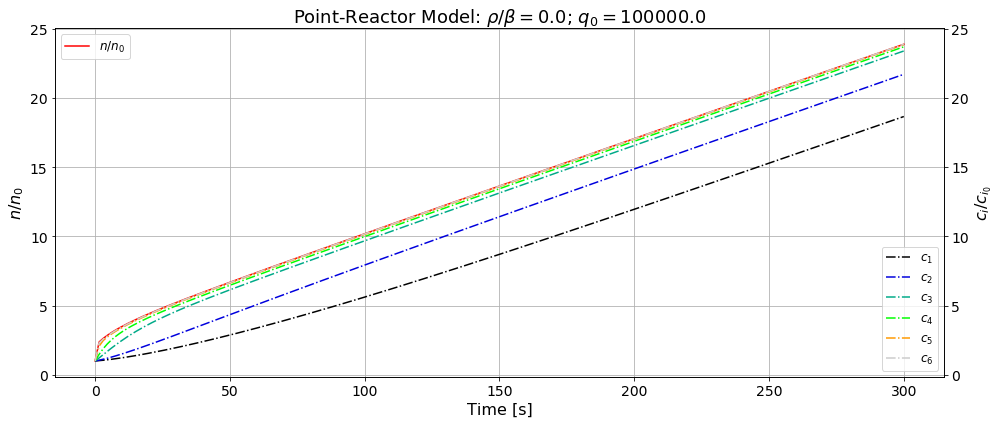

In [55]:
'''Plot neutron and delayed neutron emitter concentration in the reactor'''

plot_results(u_vec_history)

In [56]:
'''Look at the head and tail of the results'''

time_stamps = params['time_stamps']
peek(time_stamps,u_vec_history)

       time         n       c_1       c_2       c_3       c_4       c_5       c_6
0 0.000e+00 4.919e-01 2.956e+05 9.035e+05 1.618e+05 9.944e+04 8.203e+03 1.094e+03
1 1.508e+00 1.168e+00 3.025e+05 9.535e+05 1.977e+05 1.472e+05 1.700e+04 2.520e+03
2 3.015e+00 1.294e+00 3.109e+05 1.014e+06 2.358e+05 1.877e+05 2.029e+04 2.823e+03
3 4.523e+00 1.401e+00 3.205e+05 1.081e+06 2.739e+05 2.214e+05 2.238e+04 3.068e+03
4 6.030e+00 1.497e+00 3.311e+05 1.153e+06 3.111e+05 2.499e+05 2.411e+04 3.287e+03

       time         n       c_1       c_2       c_3       c_4       c_5       c_6
0 2.940e+02 1.155e+01 5.392e+06 1.923e+07 3.715e+06 2.314e+06 1.921e+05 2.566e+04
1 2.955e+02 1.160e+01 5.422e+06 1.932e+07 3.732e+06 2.324e+06 1.930e+05 2.577e+04
2 2.970e+02 1.165e+01 5.452e+06 1.941e+07 3.748e+06 2.334e+06 1.938e+05 2.589e+04
3 2.985e+02 1.170e+01 5.482e+06 1.951e+07 3.765e+06 2.345e+06 1.947e+05 2.600e+04
4 3.000e+02 1.175e+01 5.512e+06 1.960e+07 3.781e+06 2.355e+06 1.955e+05 2.611e+04



In [57]:
slope_num = (u_vec_history[-1,0] - u_vec_history[-2,0]) / (time_stamps[-1]-time_stamps[-2])/ params['q_0']
print('numerical slope = %1.5e'%slope_num)

numerical slope = 3.35070e-07


From class notes:
\begin{equation*}
q_0 \frac{\ell}{\ell + \sum_{i=1}^{6} \beta_i/\lambda_i}
\end{equation*}

In [58]:
beta = params['beta']
sum_6 = np.array(params['species_rel_yield'])*beta @ (1./np.array(params['species_decay']))
slope = gen_time /(gen_time + sum_6 )
print('analytical slope = %1.5e'%slope)

analytical slope = 3.34731e-07


In [59]:
print('slope error [%%] = %2.2f'%((slope_num-slope)/slope*100))

slope error [%] = 0.10


Since the analytical result is asymptotic, here is a convergence test:

Elapsed Time          | Numerical Normalized Slope     | Analytical  Normalized Slope     | Error   [%]  |
----------|--------------|----------------|------------------| 
100 s     |  3.41273e-07   | 3.34731e-07    |  1.95              | 
200 s     |  3.36209e-07   | 3.34731e-07    |  0.44              | 
300 s     |  3.35073e-07   | 3.34731e-07    |  0.10              | 


## <span style="color:blue">Assignment 2 (50 pts).</span><a id="p2"></a>
### <span style="color:blue">Repeat Assignment 1 using the 8-group delayed neutron emitter model. The data is suggested by the IAEA report: [INDC-NDS-0646 2013](https://www-nds.iaea.org/publications/indc/indc-nds-0646/), use the 1 MeV data. Provide the data in a tabular form with your work. Compare the result against Assignment 1 in a tabular form and make pertinent comments about the differences.
</span>

Refer to Notebook 03a

### Input Data<a id="data"></a>


For fast fission of $^{239}$Pu the following eight-group delayed neutron precursors data will be used (2013,IAEA, INDC-NDS-0646):


Delayed neutron emitter group No. | Decay half-life time ($\ln(2)/\lambda_i$,sec) | Relative yield ($\beta_i/\beta$) |
----------------------------------|-------------------------------|----------------------------------| 
1                                 | 55.6                        | 0.032                            |
2                                 | 24.3                        | 0.220                            | 
3                                 | 16.3                         | 0.089                            |  
4                                 | 5.21                         | 0.172                            | 
5                                 | 2.37                         | 0.322                            |
6                                 | 1.04                          | 0.061                            |
7                                 | 0.424                         | 0.084                               |
8                                 | 0.195                        |   0.020                             |

In [60]:
'''Parameters dictionary container'''

# make sure the params dictionary is the same except for the following modification
# do not clear the dictionary

import math
ln2 = math.log(2)

params['species_decay']     = [ln2/55.6, ln2/24.3, ln2/16.3, ln2/5.21, ln2/2.37, ln2/1.04, ln2/0.424, ln2/0.195] # 1/sec
params['species_rel_yield'] = [0.032, 0.220, 0.089, 0.172, 0.322, 0.061, 0.084, 0.020 ] 

In [61]:
import numpy as np
assert np.abs(np.sum(np.array(params['species_rel_yield']))-1.0) <= 1.e-8

In [62]:
tau = np.array(params['species_rel_yield']) @ (1./np.array(params['species_decay']))
print('weighted mean lifetime of delayed neutrons %1.2f [s]'%tau)

weighted mean lifetime of delayed neutrons 14.91 [s]


In [63]:
'''Setup up initial conditions'''

import numpy as np

# setup remaining initial conditions
setup_initial_conditions(params)

In [64]:
'''Evolve the point-reactor'''

time_final    = 300 # s
n_time_stamps = 200 # number of solution values in time

params['time_final']   = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = run_point_reactor( f_vec, params )

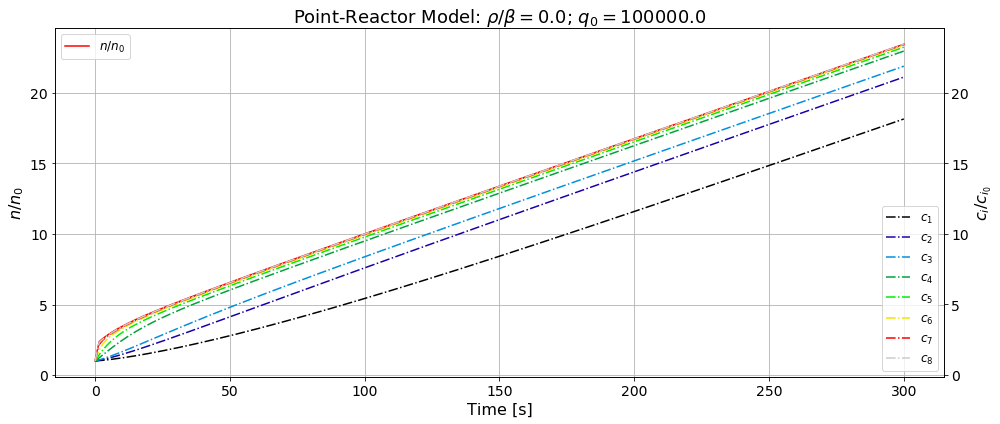

In [65]:
'''Plot neutron and delayed neutron emitter concentration in the reactor'''

plot_results(u_vec_history)

In [66]:
'''Look at the head and tail of the results'''

time_stamps = params['time_stamps']
peek(time_stamps,u_vec_history)

       time         n       c_1       c_2       c_3       c_4       c_5       c_6       c_7       c_8
0 0.000e+00 4.919e-01 2.576e+05 7.740e+05 2.100e+05 1.297e+05 1.105e+05 9.184e+03 5.156e+03 5.646e+02
1 1.508e+00 1.162e+00 2.633e+05 8.131e+05 2.257e+05 1.582e+05 1.583e+05 1.634e+04 1.113e+04 1.300e+03
2 3.015e+00 1.284e+00 2.704e+05 8.601e+05 2.442e+05 1.883e+05 2.003e+05 2.060e+04 1.291e+04 1.449e+03
3 4.523e+00 1.388e+00 2.784e+05 9.124e+05 2.645e+05 2.182e+05 2.363e+05 2.347e+04 1.411e+04 1.572e+03
4 6.030e+00 1.482e+00 2.872e+05 9.691e+05 2.861e+05 2.474e+05 2.673e+05 2.568e+04 1.514e+04 1.681e+03

       time         n       c_1       c_2       c_3       c_4       c_5       c_6       c_7       c_8
0 2.940e+02 1.134e+01 4.570e+06 1.602e+07 4.511e+06 2.925e+06 2.521e+06 2.108e+05 1.186e+05 1.300e+04
1 2.955e+02 1.139e+01 4.596e+06 1.610e+07 4.532e+06 2.938e+06 2.533e+06 2.117e+05 1.192e+05 1.306e+04
2 2.970e+02 1.144e+01 4.622e+06 1.618e+07 4.553e+06 2.951e+06 2.544e+06 2.126e+05

In [67]:
slope_num = (u_vec_history[-1,0] - u_vec_history[-2,0]) / (time_stamps[-1]-time_stamps[-2])/ params['q_0']
print('numerical slope = %1.5e'%slope_num)

numerical slope = 3.29023e-07


From class notes:
\begin{equation*}
q_0 \frac{\ell}{\ell + \sum_{i=1}^{8} \beta_i/\lambda_i}
\end{equation*}

In [68]:
beta = params['beta']
sum_8 = np.array(params['species_rel_yield'])*beta @ (1./np.array(params['species_decay']))
slope = gen_time /(gen_time + sum_8 )
print('analytical slope = %1.5e'%slope)

analytical slope = 3.28665e-07


In [69]:
print('slope error [%%] = %2.2f'%((slope_num-slope)/slope*100))

slope error [%] = 0.11


Since the analytical result is asymptotic, here is a convergence test:

Elapsed Time          | Numerical Normalized Slope     | Analytical  Normalized Slope     | Error   [%]  |
----------|--------------|----------------|------------------| 
100 s     |  4.78777e-07   | 4.74164e-07    |  1.89              | 
200 s     |  4.74772e-07   | 4.74164e-07    |  0.44              |
300 s     |  4.74241e-07   | 4.74164e-07    |  0.11              | 

Therefore the new 2013 eight-group data provide better convergence than the six-group, 1964 data.

### Comparative Analysis<a id="data"></a>

Comparing the weighted mean lifetime of delayed neutrons

\begin{equation*}
 \overline{\tau} = \frac{1}{\beta}\sum_{i=1}^{6\,\text{or}\,8} \beta_i/\lambda_i
\end{equation*}

then the relative change of this quantity is

In [71]:
'''Delayed neutron mean lifetime change'''

print('delayed neutron mean lifetime change [%%] = %2.2f'%(100*(sum_8-sum_6)/sum_6))

delayed neutron mean lifetime change [%] = 1.85


The corresponding change in normalized slope 

\begin{equation*}
\frac{\ell}{\ell + \beta\,\overline{\tau}}
\end{equation*}

for this reactor response case is 

In [72]:
'''Slope change  data'''

slope_6g = gen_time / (gen_time + sum_6)
slope_8g = gen_time / (gen_time + sum_8)

print('slope change [%%] = %2.2f'%(100*(slope_8g-slope_6g)/slope_6g))

slope change [%] = -1.81


In summary there is an overall 2% change in the response slope which is the key parameter of this step change in source:

 | Delayed Neutron Mean Lifetime Change [%]     | Slope Change   [%] |
|--------------|----------------| 
  |  1.85       | -1.81               | 



The head-to-head comparison of delayed neutron emitter decay constants and relative partial yields show greater disparity but this is not to be taken literaly because one cannot really compare six and eight groups directly.

Delayed neutron emitter group No. | Decay cte ($\lambda_i$,1/sec) | Decay cte ($\lambda_i$,1/sec) | Change [%] |
----------------------------------|-----------------------------|---------------------------------|------------|
1                                 | 0.0124                      | 0.0129  | -3.9   |
2                                 | 0.0285                      | 0.0311  | -8.4   |
3                                 | 0.0425                      | 0.134   | -68.3  |
4                                 | 0.1330                      | 0.331   | -59.82 |
5                                 | 0.2924                      | 1.26    | -76.8  |
6                                 | 0.6664                      | 3.21    | -79.2  |
7                                 | 1.6347                      | -       |  -     |
8                                 | 3.5546                      |   -     |  -     |
Average                           | 0.7956                      |  0.8298 | -4.1  |



Delayed neutron emitter group No. | Relative yield ($\beta_i/\beta$) | Relative yield ($\beta_i/\beta$) | Change [%] | 
----------------------------------|-------------------------------|-----------|-----------|
1                                 |  0.032                        | 0.038     |  -15.80  |
2                                 |  0.220                        | 0.280     |  -21.42  |
3                                 |  0.089                        | 0.216     |  -58.80  |
4                                 |  0.172                        | 0.328     |  -47.56  |
5                                 |  0.322                        | 0.103     |  212.62  |
6                                 |  0.061                        | 0.035     |  74.29   |
7                                 |  0.084                        | -         |   -  |
8                                 |  0.020                        | -         |    -  |
Average                           |  0.125                        | 0.167     | -25.1 | 




